# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "DAE"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'DAE',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups            
Sample_167  A0A1B0GUU9;P01871;P01871-2   17.542
Sample_188  Q8IYD8;Q8IYD8-2;Q8IYD8-3     17.737
Sample_207  A8MU39;H0YDU8;P53041         12.845
Sample_127  P43004;P43004-2;P43004-3     13.333
Sample_178  E7ETH0;G3XAM2;P05156         19.161
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by DAE: runs/alzheimer_study/preds/pred_real_na_DAE.csv


Sample ID   protein groups                        
Sample_163  F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3   14.155
Sample_092  Q9UKZ4;Q9UKZ4-2                          10.867
Sample_082  Q9H3T2;Q9H3T2-3                          13.236
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 11.900
            A0A075B6Q5                 12.816
            A0A075B6R2                 13.155
            A0A075B6S5                 12.722
            A0A087WSY4                 12.928
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.164
            Q9UI40;Q9UI40-2            12.192
            Q9UIW2                     13.120
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   11.914
            Q9UP79                     13.848
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.010,15.050,16.842,19.863,16.329,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.759,19.067,...,15.528,15.576,14.018,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,16.095,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.046,17.705,17.039,15.713,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,14.633,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.221,15.345,17.084,18.708,14.249,19.433,11.847,10.798
Sample_207,15.739,16.877,15.469,16.898,13.445,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,14.010,12.558,13.568,12.760,12.508,11.884,12.687,14.098,12.767,11.431
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,10.274,19.067,16.127,...,12.952,13.277,12.289,12.327,12.490,13.212,11.061,12.919,12.837,13.489
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,12.570,14.309,13.537,13.696,13.149,13.673,12.183,12.705,13.089,12.239
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,13.252,12.758,13.050,12.294,12.250,12.862,12.129,12.347,11.923,12.663
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,11.670,12.736,12.399,13.237,12.638,13.105,13.582,14.324,13.172,13.326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,13.270,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 317.97it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.62it/s]

100%|██████████| 2/2 [00:00<00:00,  6.57it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  8.56it/s]

100%|██████████| 3/3 [00:00<00:00,  5.19it/s]

100%|██████████| 3/3 [00:00<00:00,  5.61it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.55it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.18it/s]

100%|██████████| 4/4 [00:00<00:00,  4.64it/s]

100%|██████████| 4/4 [00:00<00:00,  4.94it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  7.93it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.57it/s]

 80%|████████  | 4/5 [00:00<00:00,  3.89it/s]

100%|██████████| 5/5 [00:01<00:00,  3.66it/s]

100%|██████████| 5/5 [00:01<00:00,  4.07it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  8.24it/s]

 50%|█████     | 3/6 [00:00<00:00,  6.03it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.31it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.70it/s]

100%|██████████| 6/6 [00:01<00:00,  3.35it/s]

100%|██████████| 6/6 [00:01<00:00,  3.96it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  7.66it/s]

 43%|████▎     | 3/7 [00:00<00:00,  5.66it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.47it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  4.30it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  4.20it/s]

100%|██████████| 7/7 [00:01<00:00,  4.09it/s]

100%|██████████| 7/7 [00:01<00:00,  4.48it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  8.44it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.95it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.04it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.70it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  2.61it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.66it/s]

100%|██████████| 8/8 [00:02<00:00,  2.42it/s]

100%|██████████| 8/8 [00:02<00:00,  2.80it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.35it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.12it/s]

 44%|████▍     | 4/9 [00:01<00:01,  2.67it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.52it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.44it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.41it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  2.38it/s]

100%|██████████| 9/9 [00:03<00:00,  2.65it/s]

100%|██████████| 9/9 [00:03<00:00,  2.65it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00,  9.25it/s]

 30%|███       | 3/10 [00:00<00:01,  6.29it/s]

 40%|████      | 4/10 [00:00<00:01,  5.42it/s]

 50%|█████     | 5/10 [00:00<00:01,  4.97it/s]

 60%|██████    | 6/10 [00:01<00:00,  4.68it/s]

 70%|███████   | 7/10 [00:01<00:00,  4.62it/s]

 80%|████████  | 8/10 [00:01<00:00,  4.57it/s]

 90%|█████████ | 9/10 [00:01<00:00,  4.54it/s]

100%|██████████| 10/10 [00:02<00:00,  4.53it/s]

100%|██████████| 10/10 [00:02<00:00,  4.88it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  8.64it/s]

 27%|██▋       | 3/11 [00:00<00:01,  7.27it/s]

 36%|███▋      | 4/11 [00:00<00:01,  6.86it/s]

 45%|████▌     | 5/11 [00:00<00:00,  6.27it/s]

 55%|█████▍    | 6/11 [00:00<00:00,  5.79it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  5.55it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  5.46it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  4.67it/s]

 91%|█████████ | 10/11 [00:01<00:00,  4.97it/s]

100%|██████████| 11/11 [00:01<00:00,  4.99it/s]

100%|██████████| 11/11 [00:01<00:00,  5.54it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  7.52it/s]

 25%|██▌       | 3/12 [00:00<00:01,  5.17it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.72it/s]

 42%|████▏     | 5/12 [00:01<00:01,  4.56it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.54it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  4.69it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  4.43it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  4.36it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  4.31it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  4.28it/s]

100%|██████████| 12/12 [00:02<00:00,  4.51it/s]

100%|██████████| 12/12 [00:02<00:00,  4.61it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  6.33it/s]

 23%|██▎       | 3/13 [00:00<00:01,  5.43it/s]

 31%|███       | 4/13 [00:00<00:01,  4.78it/s]

 38%|███▊      | 5/13 [00:01<00:01,  4.60it/s]

 46%|████▌     | 6/13 [00:01<00:01,  4.58it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  4.29it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  4.51it/s]

 69%|██████▉   | 9/13 [00:01<00:00,  4.55it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  4.65it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  4.65it/s]

 92%|█████████▏| 12/13 [00:02<00:00,  4.83it/s]

100%|██████████| 13/13 [00:02<00:00,  4.79it/s]

100%|██████████| 13/13 [00:02<00:00,  4.74it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  7.83it/s]

 21%|██▏       | 3/14 [00:00<00:01,  6.01it/s]

 29%|██▊       | 4/14 [00:00<00:01,  5.14it/s]

 36%|███▌      | 5/14 [00:00<00:02,  4.48it/s]

 43%|████▎     | 6/14 [00:01<00:01,  4.32it/s]

 50%|█████     | 7/14 [00:01<00:01,  4.17it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  4.46it/s]

 64%|██████▍   | 9/14 [00:01<00:01,  4.45it/s]

 71%|███████▏  | 10/14 [00:02<00:00,  4.38it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  4.44it/s]

 86%|████████▌ | 12/14 [00:02<00:00,  4.24it/s]

 93%|█████████▎| 13/14 [00:02<00:00,  4.09it/s]

100%|██████████| 14/14 [00:03<00:00,  3.97it/s]

100%|██████████| 14/14 [00:03<00:00,  4.41it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  7.68it/s]

 20%|██        | 3/15 [00:00<00:02,  5.30it/s]

 27%|██▋       | 4/15 [00:00<00:02,  4.90it/s]

 33%|███▎      | 5/15 [00:00<00:02,  4.73it/s]

 40%|████      | 6/15 [00:01<00:02,  4.44it/s]

 47%|████▋     | 7/15 [00:01<00:01,  4.47it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  4.57it/s]

 60%|██████    | 9/15 [00:01<00:01,  4.57it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  4.56it/s]

 73%|███████▎  | 11/15 [00:02<00:00,  4.48it/s]

 80%|████████  | 12/15 [00:02<00:00,  4.21it/s]

 87%|████████▋ | 13/15 [00:02<00:00,  4.10it/s]

 93%|█████████▎| 14/15 [00:03<00:00,  4.15it/s]

100%|██████████| 15/15 [00:03<00:00,  4.02it/s]

100%|██████████| 15/15 [00:03<00:00,  4.45it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.003      0.043 0.013          0.660 0.412       0.093   
2             0.004 0.003      0.042 0.015          0.778 0.089       0.693   
3             0.005 0.005      0.056 0.020          0.783 0.099       0.717   
4             0.004 0.004      0.047 0.019          0.792 0.092       0.749   
5             0.003 0.000      0.040 0.011          0.794 0.095       0.751   
6             0.005 0.004      0.053 0.018          0.787 0.093       0.760   
7             0.004 0.003      0.045 0.015          0.799 0.085       0.808   
8             0.007 0.007      0.066 0.033          0.805 0.084       0.811   
9             0.006 0.006      0.057 0.023          0.804 0.084       0.805   
10            0.004 0.003      0.033 0.010          0.797 0.089       0.802   
11            0.004 0.002      0.034 0.006          0.801 0.090       0.802   
12            0.003 0.001      0.032 0.003          0.788 0.093       0.791   
13            0.003 0.001      0.035 0.011          0.787 0.095       0.790   
14            0.003 0.000      0.036 0.007          0.785 0.099       0.782   
15            0.004 0.002      0.035 0.004          0.777 0.096       0.768   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.082   0.156 0.126                  0.539 0.039        0.845   
2          0.108   0.727 0.078                  0.772 0.060        0.850   
3          0.104   0.742 0.075                  0.783 0.061        0.858   
4          0.106   0.764 0.073                  0.800 0.060        0.862   
5          0.099   0.768 0.079                  0.802 0.066        0.882   
6          0.099   0.769 0.077                  0.803 0.063        0.884   
7          0.096   0.800 0.071                  0.828 0.061        0.904   
8          0.100   0.804 0.071                  0.832 0.061        0.902   
9          0.101   0.800 0.072                  0.829 0.062        0.902   
10         0.102   0.795 0.076                  0.825 0.066        0.900   
11         0.102   0.797 0.075                  0.826 0.064        0.896   
12         0.107   0.785 0.078                  0.816 0.068        0.893   
13         0.109   0.784 0.079                  0.815 0.068        0.891   
14         0.102   0.778 0.074                  0.810 0.063        0.899   
15         0.101   0.767 0.073                  0.800 0.062        0.897   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.066                  0.817 0.089        210.000 0.000  
2          0.060                  0.801 0.077        210.000 0.000  
3          0.058                  0.820 0.077        210.000 0.000  
4          0.058                  0.819 0.076        210.000 0.000  
5          0.054                  0.844 0.071        210.000 0.000  
6          0.055                  0.846 0.074        210.000 0.000  
7          0.051                  0.878 0.064        210.000 0.000  
8          0.052                  0.878 0.062        210.000 0.000  
9          0.052                  0.878 0.063        210.000 0.000  
10         0.053                  0.877 0.062        210.000 0.000  
11         0.053                  0.871 0.064        210.000 0.000  
12         0.055                  0.870 0.064        210.000 0.000  
13         0.055                  0.868 0.064        210.000 0.000  
14         0.053                  0.884 0.057        210.000 0.000  
15         0.053                  0.882 0.056 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 523.44it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.68it/s]

100%|██████████| 2/2 [00:00<00:00,  6.66it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  7.94it/s]

100%|██████████| 3/3 [00:00<00:00,  5.24it/s]

100%|██████████| 3/3 [00:00<00:00,  5.60it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.31it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.04it/s]

100%|██████████| 4/4 [00:00<00:00,  3.78it/s]

100%|██████████| 4/4 [00:00<00:00,  4.06it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.99it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.14it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.21it/s]

100%|██████████| 5/5 [00:01<00:00,  2.83it/s]

100%|██████████| 5/5 [00:01<00:00,  3.27it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  7.28it/s]

 50%|█████     | 3/6 [00:00<00:00,  5.21it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.37it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  4.26it/s]

100%|██████████| 6/6 [00:01<00:00,  4.04it/s]

100%|██████████| 6/6 [00:01<00:00,  4.43it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  8.71it/s]

 43%|████▎     | 3/7 [00:00<00:00,  6.59it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  6.18it/s]

 71%|███████▏  | 5/7 [00:00<00:00,  5.31it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  5.10it/s]

100%|██████████| 7/7 [00:01<00:00,  5.06it/s]

100%|██████████| 7/7 [00:01<00:00,  5.54it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  7.32it/s]

 38%|███▊      | 3/8 [00:00<00:00,  5.82it/s]

 50%|█████     | 4/8 [00:00<00:00,  5.13it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  4.28it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  4.26it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  4.06it/s]

100%|██████████| 8/8 [00:01<00:00,  4.01it/s]

100%|██████████| 8/8 [00:01<00:00,  4.44it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  7.77it/s]

 33%|███▎      | 3/9 [00:00<00:01,  5.73it/s]

 44%|████▍     | 4/9 [00:00<00:00,  5.05it/s]

 56%|█████▌    | 5/9 [00:00<00:00,  4.66it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  4.43it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  4.48it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  4.26it/s]

100%|██████████| 9/9 [00:01<00:00,  4.37it/s]

100%|██████████| 9/9 [00:01<00:00,  4.68it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00,  8.00it/s]

 30%|███       | 3/10 [00:00<00:01,  4.65it/s]

 40%|████      | 4/10 [00:00<00:01,  3.63it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.17it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.17it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.96it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.95it/s]

 90%|█████████ | 9/10 [00:02<00:00,  2.79it/s]

100%|██████████| 10/10 [00:03<00:00,  2.78it/s]

100%|██████████| 10/10 [00:03<00:00,  3.13it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  4.64it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.12it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.75it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.47it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  2.43it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.56it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.73it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.90it/s]

 91%|█████████ | 10/11 [00:03<00:00,  3.11it/s]

100%|██████████| 11/11 [00:03<00:00,  3.28it/s]

100%|██████████| 11/11 [00:03<00:00,  2.94it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  6.96it/s]

 25%|██▌       | 3/12 [00:00<00:01,  5.05it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.53it/s]

 42%|████▏     | 5/12 [00:01<00:01,  4.37it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.16it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.89it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  3.34it/s]

 75%|███████▌  | 9/12 [00:02<00:01,  2.98it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  2.54it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  2.31it/s]

100%|██████████| 12/12 [00:03<00:00,  2.28it/s]

100%|██████████| 12/12 [00:03<00:00,  3.06it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  4.28it/s]

 23%|██▎       | 3/13 [00:00<00:03,  2.97it/s]

 31%|███       | 4/13 [00:01<00:03,  2.74it/s]

 38%|███▊      | 5/13 [00:01<00:03,  2.52it/s]

 46%|████▌     | 6/13 [00:02<00:02,  2.66it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.82it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.83it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.96it/s]

 77%|███████▋  | 10/13 [00:03<00:00,  3.15it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  3.37it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  3.60it/s]

100%|██████████| 13/13 [00:04<00:00,  3.53it/s]

100%|██████████| 13/13 [00:04<00:00,  3.12it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  6.32it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.46it/s]

 29%|██▊       | 4/14 [00:00<00:02,  4.26it/s]

 36%|███▌      | 5/14 [00:01<00:02,  4.07it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.84it/s]

 50%|█████     | 7/14 [00:01<00:01,  3.88it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  3.86it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.54it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.12it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.98it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  2.79it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  2.77it/s]

100%|██████████| 14/14 [00:04<00:00,  2.63it/s]

100%|██████████| 14/14 [00:04<00:00,  3.28it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.03it/s]

 20%|██        | 3/15 [00:00<00:03,  3.50it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.12it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.90it/s]

 40%|████      | 6/15 [00:02<00:03,  2.65it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.53it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.43it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.49it/s]

 67%|██████▋   | 10/15 [00:03<00:02,  2.48it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.47it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.71it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.83it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.87it/s]

100%|██████████| 15/15 [00:05<00:00,  2.97it/s]

100%|██████████| 15/15 [00:05<00:00,  2.81it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.001      0.034 0.004          0.158 0.330       0.020   
2             0.003 0.000      0.035 0.003          0.725 0.225       0.215   
3             0.003 0.000      0.034 0.001          0.764 0.097       0.744   
4             0.004 0.004      0.043 0.017          0.770 0.090       0.753   
5             0.004 0.002      0.043 0.018          0.810 0.096       0.743   
6             0.003 0.000      0.034 0.000          0.822 0.088       0.785   
7             0.003 0.000      0.031 0.005          0.824 0.089       0.796   
8             0.003 0.000      0.032 0.002          0.823 0.089       0.790   
9             0.007 0.005      0.057 0.014          0.818 0.092       0.781   
10            0.006 0.007      0.056 0.030          0.855 0.077       0.826   
11            0.005 0.004      0.047 0.021          0.851 0.077       0.824   
12            0.004 0.003      0.044 0.019          0.865 0.080       0.822   
13            0.005 0.005      0.052 0.022          0.855 0.079       0.845   
14            0.004 0.003      0.052 0.023          0.855 0.079       0.850   
15            0.005 0.004      0.041 0.012          0.857 0.079       0.832   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.048   0.034 0.079                  0.505 0.021        0.868   
2          0.094   0.315 0.114                  0.569 0.044        0.710   
3          0.097   0.750 0.080                  0.786 0.068        0.874   
4          0.099   0.757 0.075                  0.792 0.063        0.872   
5          0.092   0.771 0.078                  0.806 0.063        0.888   
6          0.100   0.800 0.079                  0.830 0.065        0.900   
7          0.097   0.805 0.071                  0.834 0.059        0.901   
8          0.106   0.801 0.077                  0.831 0.063        0.899   
9          0.106   0.794 0.080                  0.825 0.066        0.897   
10         0.103   0.837 0.072                  0.861 0.060        0.932   
11         0.101   0.834 0.073                  0.859 0.061        0.931   
12         0.101   0.839 0.072                  0.863 0.060        0.935   
13         0.097   0.846 0.069                  0.869 0.059        0.935   
14         0.094   0.850 0.069                  0.872 0.060        0.935   
15         0.104   0.840 0.072                  0.864 0.061        0.934   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.060                  0.834 0.088        210.000 0.000  
2          0.102                  0.667 0.107        210.000 0.000  
3          0.057                  0.843 0.075        210.000 0.000  
4          0.057                  0.842 0.074        210.000 0.000  
5          0.055                  0.862 0.072        210.000 0.000  
6          0.054                  0.879 0.071        210.000 0.000  
7          0.054                  0.878 0.073        210.000 0.000  
8          0.055                  0.876 0.073        210.000 0.000  
9          0.057                  0.875 0.073        210.000 0.000  
10         0.042                  0.912 0.055        210.000 0.000  
11         0.043                  0.910 0.056        210.000 0.000  
12         0.042                  0.916 0.055        210.000 0.000  
13         0.040                  0.916 0.051        210.000 0.000  
14         0.041                  0.916 0.052        210.000 0.000  
15         0.041                  0.918 0.050 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1128.41it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 28.65it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 22.02it/s]

100%|██████████| 3/3 [00:00<00:00, 19.35it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 16.31it/s]

100%|██████████| 4/4 [00:00<00:00, 15.97it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00, 17.11it/s]

 80%|████████  | 4/5 [00:00<00:00, 15.73it/s]

100%|██████████| 5/5 [00:00<00:00, 15.08it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 26.71it/s]

100%|██████████| 6/6 [00:00<00:00, 17.63it/s]

100%|██████████| 6/6 [00:00<00:00, 18.46it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 18.85it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 14.42it/s]

100%|██████████| 7/7 [00:00<00:00, 14.41it/s]

100%|██████████| 7/7 [00:00<00:00, 14.49it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 22.75it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 16.24it/s]

100%|██████████| 8/8 [00:00<00:00, 16.10it/s]

100%|██████████| 8/8 [00:00<00:00, 16.62it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 17.17it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 13.03it/s]

 78%|███████▊  | 7/9 [00:00<00:00, 11.89it/s]

100%|██████████| 9/9 [00:00<00:00, 11.47it/s]

100%|██████████| 9/9 [00:00<00:00, 12.00it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 21.32it/s]

 60%|██████    | 6/10 [00:00<00:00, 15.42it/s]

 80%|████████  | 8/10 [00:00<00:00, 16.17it/s]

100%|██████████| 10/10 [00:00<00:00, 14.81it/s]

100%|██████████| 10/10 [00:00<00:00, 15.45it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 28.08it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 17.44it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 15.09it/s]

 91%|█████████ | 10/11 [00:00<00:00, 13.16it/s]

100%|██████████| 11/11 [00:00<00:00, 14.32it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 24.31it/s]

 50%|█████     | 6/12 [00:00<00:00, 16.52it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 14.99it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 14.59it/s]

100%|██████████| 12/12 [00:00<00:00, 14.82it/s]

100%|██████████| 12/12 [00:00<00:00, 15.45it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 19.68it/s]

 38%|███▊      | 5/13 [00:00<00:00, 15.62it/s]

 54%|█████▍    | 7/13 [00:00<00:00, 15.26it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 13.26it/s]

 85%|████████▍ | 11/13 [00:00<00:00, 12.79it/s]

100%|██████████| 13/13 [00:00<00:00, 11.75it/s]

100%|██████████| 13/13 [00:01<00:00, 12.89it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 20.05it/s]

 43%|████▎     | 6/14 [00:00<00:00, 16.54it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 15.84it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 15.56it/s]

 86%|████████▌ | 12/14 [00:00<00:00, 13.85it/s]

100%|██████████| 14/14 [00:00<00:00, 12.89it/s]

100%|██████████| 14/14 [00:00<00:00, 14.31it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 24.23it/s]

 40%|████      | 6/15 [00:00<00:00, 17.72it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 17.38it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 16.53it/s]

 80%|████████  | 12/15 [00:00<00:00, 15.84it/s]

 93%|█████████▎| 14/15 [00:00<00:00, 15.70it/s]

100%|██████████| 15/15 [00:00<00:00, 16.30it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.005      0.054 0.022          0.000 0.000       0.000   
2             0.004 0.003      0.047 0.017          0.626 0.108       0.459   
3             0.005 0.007      0.053 0.021          0.636 0.087       0.547   
4             0.005 0.004      0.046 0.016          0.697 0.085       0.668   
5             0.005 0.004      0.055 0.022          0.688 0.087       0.659   
6             0.005 0.003      0.046 0.017          0.688 0.087       0.656   
7             0.005 0.003      0.059 0.026          0.689 0.088       0.645   
8             0.004 0.002      0.043 0.016          0.695 0.083       0.644   
9             0.004 0.003      0.051 0.021          0.696 0.085       0.634   
10            0.004 0.001      0.042 0.015          0.684 0.086       0.632   
11            0.006 0.005      0.058 0.026          0.704 0.083       0.675   
12            0.005 0.005      0.050 0.019          0.700 0.080       0.663   
13            0.005 0.004      0.052 0.021          0.700 0.079       0.671   
14            0.006 0.005      0.060 0.018          0.696 0.076       0.663   
15            0.006 0.005      0.061 0.021          0.702 0.081       0.657   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.740   
2          0.090   0.522 0.076                  0.625 0.053        0.708   
3          0.095   0.583 0.077                  0.658 0.058        0.769   
4          0.095   0.677 0.071                  0.726 0.057        0.812   
5          0.097   0.668 0.072                  0.718 0.059        0.808   
6          0.101   0.667 0.077                  0.718 0.061        0.805   
7          0.104   0.661 0.079                  0.715 0.062        0.804   
8          0.115   0.663 0.087                  0.718 0.065        0.810   
9          0.112   0.659 0.084                  0.715 0.065        0.808   
10         0.114   0.652 0.085                  0.708 0.066        0.804   
11         0.121   0.684 0.085                  0.733 0.065        0.824   
12         0.112   0.676 0.080                  0.727 0.061        0.819   
13         0.117   0.679 0.080                  0.729 0.062        0.816   
14         0.117   0.673 0.082                  0.725 0.062        0.813   
15         0.108   0.673 0.078                  0.725 0.059        0.809   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.068                  0.684 0.085        210.000 0.000  
2          0.062                  0.664 0.070        210.000 0.000  
3          0.059                  0.731 0.064        210.000 0.000  
4          0.056                  0.765 0.065        210.000 0.000  
5          0.058                  0.762 0.064        210.000 0.000  
6          0.058                  0.758 0.063        210.000 0.000  
7          0.058                  0.761 0.061        210.000 0.000  
8          0.059                  0.765 0.069        210.000 0.000  
9          0.059                  0.755 0.075        210.000 0.000  
10         0.058                  0.753 0.077        210.000 0.000  
11         0.057                  0.766 0.075        210.000 0.000  
12         0.057                  0.760 0.076        210.000 0.000  
13         0.057                  0.757 0.076        210.000 0.000  
14         0.056                  0.755 0.075        210.000 0.000  
15         0.057                  0.751 0.073 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,8,9,15
score_time,8,9,15
test_precision,8,12,11
test_recall,8,14,11
test_f1,8,14,11
test_balanced_accuracy,8,14,11
test_roc_auc,7,12,11
test_average_precision,14,15,11
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.01it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.35it/s]

 33%|███▎      | 4/12 [00:01<00:02,  2.85it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.56it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.39it/s]

 58%|█████▊    | 7/12 [00:02<00:02,  2.47it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.57it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.71it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.81it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  3.00it/s]

100%|██████████| 12/12 [00:04<00:00,  3.16it/s]

100%|██████████| 12/12 [00:04<00:00,  2.88it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 22.06it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 16.51it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 16.89it/s]

 91%|█████████ | 10/11 [00:00<00:00, 14.94it/s]

100%|██████████| 11/11 [00:00<00:00, 15.09it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.26it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.79it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.21it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.14it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.24it/s]

100%|██████████| 7/7 [00:02<00:00,  3.25it/s]

100%|██████████| 7/7 [00:02<00:00,  3.39it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve.pdf


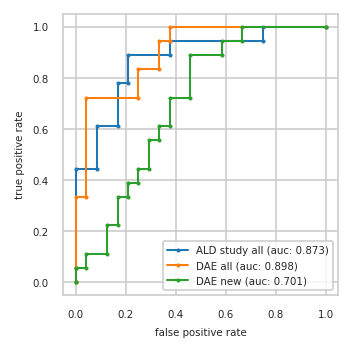

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       DAE all       DAE new      
             fpr   tpr     fpr   tpr     fpr   tpr
0          0.000 0.000   0.000 0.000   0.000 0.000
1          0.000 0.056   0.000 0.056   0.000 0.056
2          0.000 0.444   0.000 0.333   0.042 0.056
3          0.083 0.444   0.042 0.333   0.042 0.111
4          0.083 0.611   0.042 0.722   0.125 0.111
5          0.167 0.611   0.250 0.722   0.125 0.222
6          0.167 0.778   0.250 0.833   0.167 0.222
7          0.208 0.778   0.333 0.833   0.167 0.333
8          0.208 0.889   0.333 0.944   0.208 0.333
9          0.375 0.889   0.375 0.944   0.208 0.389
10         0.375 0.944   0.375 1.000   0.250 0.389
11         0.750 0.944   1.000 1.000   0.250 0.444
12         0.750 1.000     NaN   NaN   0.292 0.444
13         1.000 1.000     NaN   NaN   0.292 0.556
14           NaN   NaN     NaN   NaN   0.333 0.556
15           NaN   NaN     NaN   NaN   0.333 0.611
16           NaN   NaN     NaN   NaN   0.375 0.611
17           NaN   NaN     NaN   NaN   0.375 0.722
18           NaN   NaN     NaN   NaN   0.458 0.722
19           NaN   NaN     NaN   NaN   0.458 0.889
20           NaN   NaN     NaN   NaN   0.583 0.889
21           NaN   NaN     NaN   NaN   0.583 0.944
22           NaN   NaN     NaN   NaN   0.667 0.944
23           NaN   NaN     NaN   NaN   0.667 1.000
24           NaN   NaN     NaN   NaN   1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,DAE all,DAE new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,P31946;P31946-2,Q13641,A0A0J9YW36;Q9NZ72;Q9NZ72-2
2,P09960;P09960-4,Q01995,P07900;P07900-2
3,P04075,P02741,Q8TEA8
4,P61981,P04075,P31321
5,C9JF17;P05090,Q9Y2T3;Q9Y2T3-3,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
6,Q6EMK4,P61981,P51688
7,None,P14174,Q96GD0
8,None,Q14894,Q9NUQ9


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve.pdf


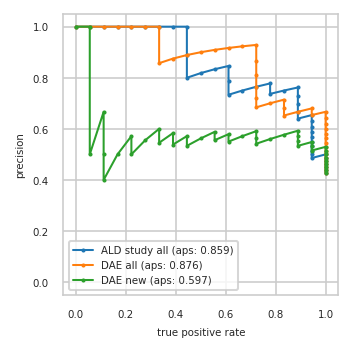

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all         DAE all         DAE new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.500 1.000
7          0.486 0.944     0.514 1.000     0.514 1.000
8          0.500 0.944     0.529 1.000     0.529 1.000
9          0.515 0.944     0.545 1.000     0.515 0.944
10         0.531 0.944     0.562 1.000     0.531 0.944
11         0.548 0.944     0.581 1.000     0.548 0.944
12         0.567 0.944     0.600 1.000     0.533 0.889
13         0.586 0.944     0.621 1.000     0.552 0.889
14         0.607 0.944     0.643 1.000     0.571 0.889
15         0.630 0.944     0.667 1.000     0.593 0.889
16         0.654 0.944     0.654 0.944     0.577 0.833
17         0.640 0.889     0.680 0.944     0.560 0.778
18         0.667 0.889     0.667 0.889     0.542 0.722
19         0.696 0.889     0.652 0.833     0.565 0.722
20         0.727 0.889     0.682 0.833     0.591 0.722
21         0.762 0.889     0.714 0.833     0.571 0.667
22         0.750 0.833     0.700 0.778     0.550 0.611
23         0.737 0.778     0.684 0.722     0.579 0.611
24         0.778 0.778     0.722 0.722     0.556 0.556
25         0.765 0.722     0.765 0.722     0.588 0.556
26         0.750 0.667     0.812 0.722     0.562 0.500
27         0.733 0.611     0.867 0.722     0.533 0.444
28         0.786 0.611     0.929 0.722     0.571 0.444
29         0.846 0.611     0.923 0.667     0.538 0.389
30         0.833 0.556     0.917 0.611     0.583 0.389
31         0.818 0.500     0.909 0.556     0.545 0.333
32         0.800 0.444     0.900 0.500     0.600 0.333
33         0.889 0.444     0.889 0.444     0.556 0.278
34         1.000 0.444     0.875 0.389     0.500 0.222
35         1.000 0.389     0.857 0.333     0.571 0.222
36         1.000 0.333     1.000 0.333     0.500 0.167
37         1.000 0.278     1.000 0.278     0.400 0.111
38         1.000 0.222     1.000 0.222     0.500 0.111
39         1.000 0.167     1.000 0.167     0.667 0.111
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve_train.pdf


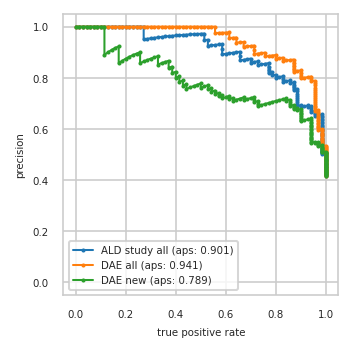

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve_train.pdf


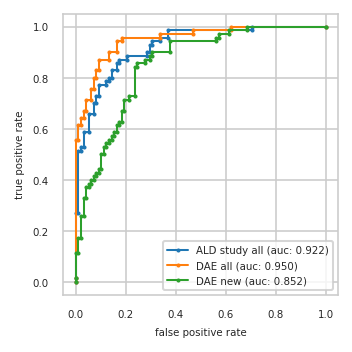

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_DAE all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_DAE all.pkl'),
 'results_DAE new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_DAE new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve_train.pdf')}